In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
import re
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Data Preprocessing

In [2]:
# Dataframe
df = pd.read_csv("C:/Users/user/Downloads/tweet_emotions.csv/tweet_emotions.csv")

In [3]:
nan_count = df['content'].isna().sum()
print(f"Number of NaN values in 'content' column: {nan_count}")

Number of NaN values in 'content' column: 0


In [4]:
d = df.duplicated()
d.sum()

0

In [5]:
# Function to display information about the dataset
def display_info(df):
    print("Dataset Info:\n")
    print(df.info())
    print("\nClass Distribution:\n")
    print(df['sentiment'].value_counts())

display_info(df)

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB
None

Class Distribution:

sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64


In [6]:
# Encode labels
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])


In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer_obj = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Cleaning function
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'@[\w]*', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Lemmatizer
def lemmatizer(text):
    if not text or not isinstance(text, str):
        return ""
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer_obj.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(lemmatized).strip()

# Drop rows where 'content' is NaN first
df = df.dropna(subset=['content']).copy()

# Clean and lemmatize
df['cleaned_text'] = df['content'].apply(clean_text).apply(lemmatizer)

# Drop any resulting NaNs or empty strings in cleaned_text
df = df[df['cleaned_text'].str.strip().astype(bool)].copy()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
print("Remaining samples:", len(df))
print("Example cleaned text:", df['cleaned_text'].iloc[0])

Remaining samples: 39785
Example cleaned text: know listenin bad habit earlier started freakin part


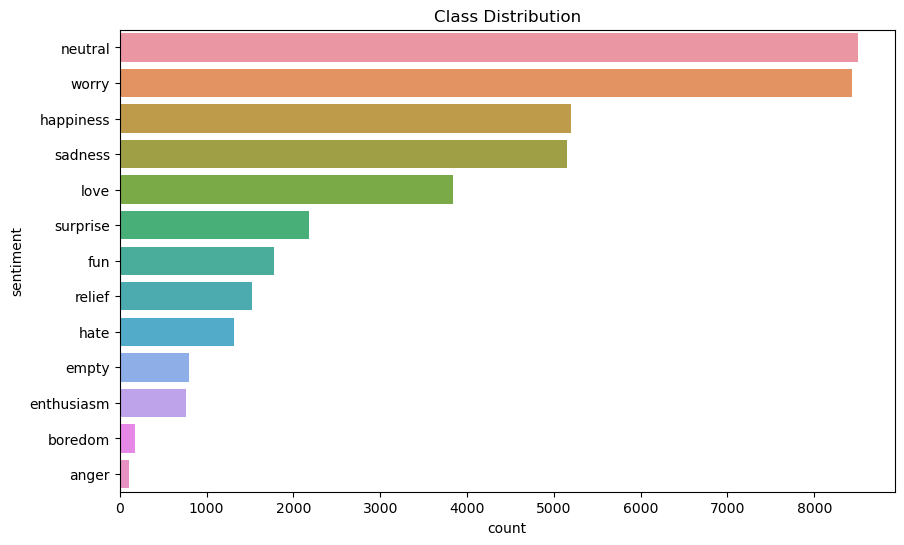

In [9]:
# Graph plotting on Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='sentiment', order=df['sentiment'].value_counts().index)
plt.title("Class Distribution")
plt.show()

In [10]:
# Oversampling and splitting data

X = df['cleaned_text']
y = df['sentiment_encoded']



oversampler = RandomOverSampler(random_state=42)
X_resampled_df, y_resampled = oversampler.fit_resample(X.values.reshape(-1,1), y)
X_resampled = X_resampled_df.flatten() 


X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [11]:
# Feature Extraction using TF-IDF
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

In [12]:
scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse data like TF-IDF
X_train_scaled = scaler.fit_transform(X_train_tfidf)
X_val_scaled = scaler.transform(X_val_tfidf)
X_test_scaled = scaler.transform(X_test_tfidf)

## Baseline Models

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

# Initializing and training the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_lr_test_pred = lr_model.predict(X_test_scaled)

# Calculate the weighted F1-Score
lr_test_f1 = f1_score(y_test, y_lr_test_pred, average='weighted')
print(f"Logistic Regression Weighted F1-Score: {lr_test_f1:.4f}")

# Display the classification report
lr_test_report = classification_report(y_test, y_lr_test_pred, target_names=label_encoder.classes_)
print("Logistic Regression Performance:")
print(lr_test_report)


Logistic Regression Weighted F1-Score: 0.7254
Logistic Regression Performance:
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00      1275
     boredom       1.00      1.00      1.00      1275
       empty       0.86      0.97      0.92      1275
  enthusiasm       0.88      0.97      0.92      1276
         fun       0.76      0.91      0.83      1276
   happiness       0.59      0.51      0.55      1275
        hate       0.82      0.97      0.89      1276
        love       0.66      0.67      0.67      1275
     neutral       0.32      0.23      0.27      1275
      relief       0.76      0.90      0.83      1275
     sadness       0.60      0.53      0.56      1276
    surprise       0.71      0.80      0.75      1275
       worry       0.33      0.20      0.25      1275

    accuracy                           0.74     16579
   macro avg       0.72      0.74      0.73     16579
weighted avg       0.72      0.74      0.73     16579



C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

# Initializing and training the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_rf_test_pred = rf_model.predict(X_test_tfidf)

# Calculate the weighted F1-Score
rf_test_f1 = f1_score(y_test, y_rf_test_pred, average='weighted')
print(f"Random Forest Weighted F1-Score: {rf_test_f1:.4f}")

# Display the classification report
rf_test_report = classification_report(y_test, y_rf_test_pred, target_names=label_encoder.classes_)
print("Random Forest Performance:")
print(rf_test_report)


Random Forest Weighted F1-Score: 0.8093
Random Forest Performance:
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00      1275
     boredom       0.99      1.00      1.00      1275
       empty       0.92      0.98      0.95      1275
  enthusiasm       0.93      0.98      0.96      1276
         fun       0.89      0.96      0.93      1276
   happiness       0.68      0.63      0.65      1275
        hate       0.91      0.98      0.94      1276
        love       0.79      0.83      0.81      1275
     neutral       0.42      0.41      0.42      1275
      relief       0.88      0.96      0.92      1275
     sadness       0.70      0.65      0.68      1276
    surprise       0.88      0.91      0.90      1275
       worry       0.46      0.33      0.38      1275

    accuracy                           0.82     16579
   macro avg       0.80      0.82      0.81     16579
weighted avg       0.80      0.82      0.81     16579



## Evaluation

In [15]:
# Compare Results
results = {
    "Model": ["Logistic Regression", "Random Forest"],
    "Test Weighted F1-Score": [lr_test_f1, rf_test_f1]
}
results_df = pd.DataFrame(results)
print(results_df)


                 Model  Test Weighted F1-Score
0  Logistic Regression                0.725358
1        Random Forest                0.809305


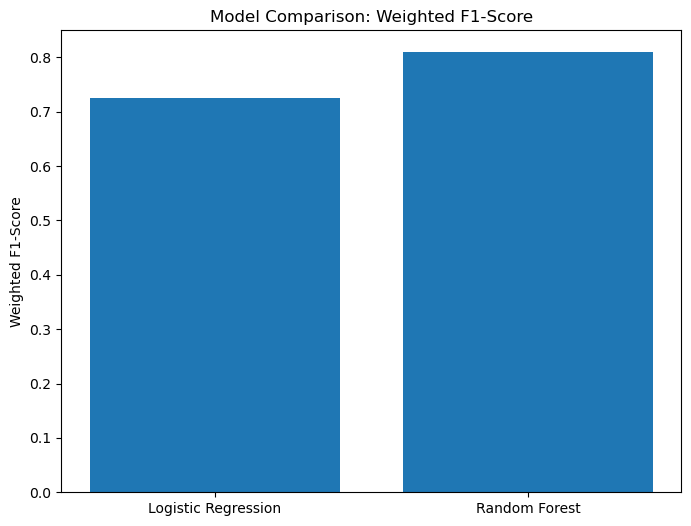

In [16]:
# Bar graph of Overall Performance
plt.figure(figsize=(8, 6))
plt.bar(results_df['Model'], results_df['Test Weighted F1-Score'])
plt.title("Model Comparison: Weighted F1-Score")
plt.ylabel("Weighted F1-Score")
plt.show()